**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-19 19:54:34--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  8,29MB/s    in 0,2s    

2022-10-19 19:54:35 (8,29 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [22]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [23]:
print(df.shape, df_full_train.shape, df_val.shape, df_test.shape)

(20640, 10) (16512, 10) (4128, 9) (4128, 9)


- We will use `DictVectorizer` to turn train and validation into matrices.

In [24]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
target = "median_house_value"

features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [25]:
X_train.shape

(12384, 13)

In [26]:
X_val.shape

(4128, 13)

In [27]:
val_dicts[0]

{'longitude': -118.35,
 'latitude': 34.07,
 'housing_median_age': 45.0,
 'total_rooms': 7803.0,
 'total_bedrooms': 2154.0,
 'population': 3359.0,
 'households': 2041.0,
 'median_income': 3.3594,
 'ocean_proximity': '<1H OCEAN'}

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [28]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=1)

In [29]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/hydroinfmtk/mambaforge/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


- Which feature is used for splitting the data?

- Answer: **ocean_proximity=INLAND**

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [30]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [31]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2456601287532493

- What's the RMSE of this model on validation?

- Answer: **0.25**

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [34]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
df_scores

,n_estimators,rmse
0,10,0.245660
1,20,0.238831
2,30,0.235335
3,40,0.234257
4,50,0.232991
5,60,0.232767
6,70,0.232337
7,80,0.232403
8,90,0.232107
9,100,0.231928


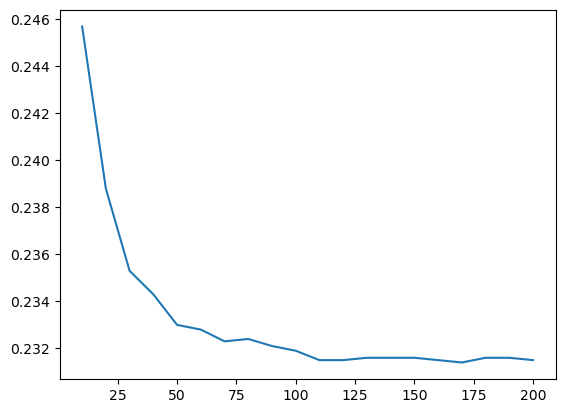

In [39]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(4))

- After which value of `n_estimators` does RMSE stop improving?

- Answer: In my visual inspection it would be 110, but only available after is **150**

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [40]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                                max_depth=d,
                                random_state=1, n_jobs=-1,
                                warm_start=True)
    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.254599
1,10,20,0.252577
2,10,30,0.251463
3,10,40,0.250919
4,10,50,0.250069
...,...,...,...
75,25,160,0.231485
76,25,170,0.231436
77,25,180,0.231552
78,25,190,0.231530


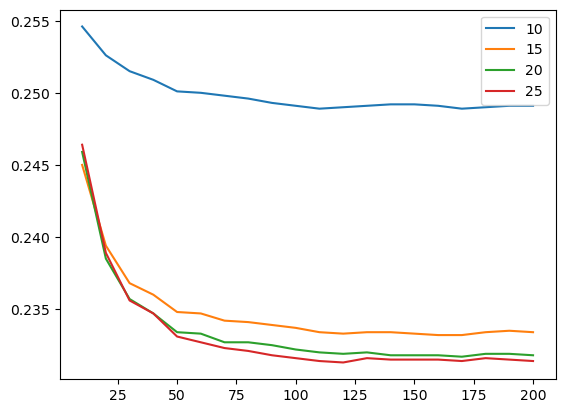

In [43]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse.round(4), label=d)

plt.legend(); 

- What's the best `max_depth`:

- Answer: **25**

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [44]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [45]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [48]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

/home/hydroinfmtk/mambaforge/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145


- What's the most important feature?

- Answer: **median_income**

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [49]:
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [50]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [51]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [52]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                    verbose_eval=5, evals=watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13245
[5]	train-rmse:1.40218	val-rmse:1.40741
[10]	train-rmse:0.34481	val-rmse:0.35782
[15]	train-rmse:0.23555	val-rmse:0.26044
[20]	train-rmse:0.21580	val-rmse:0.24624
[25]	train-rmse:0.20395	val-rmse:0.24099
[30]	train-rmse:0.19440	val-rmse:0.23741
[35]	train-rmse:0.18637	val-rmse:0.23562
[40]	train-rmse:0.17983	val-rmse:0.23419
[45]	train-rmse:0.17468	val-rmse:0.23279
[50]	train-rmse:0.16934	val-rmse:0.23097
[55]	train-rmse:0.16546	val-rmse:0.23039
[60]	train-rmse:0.16177	val-rmse:0.22950
[65]	train-rmse:0.15762	val-rmse:0.22857
[70]	train-rmse:0.15323	val-rmse:0.22787
[75]	train-rmse:0.15010	val-rmse:0.22755
[80]	train-rmse:0.14564	val-rmse:0.22611
[85]	train-rmse:0.14166	val-rmse:0.22579
[90]	train-rmse:0.13892	val-rmse:0.22628
[95]	train-rmse:0.13553	val-rmse:0.22630
[99]	train-rmse:0.13299	val-rmse:0.22610


In [53]:
xgb_params = {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                    verbose_eval=5, evals=watchlist)

[0]	train-rmse:10.44372	val-rmse:10.44938
[5]	train-rmse:6.17513	val-rmse:6.17987
[10]	train-rmse:3.65741	val-rmse:3.66135
[15]	train-rmse:2.17500	val-rmse:2.17928
[20]	train-rmse:1.30499	val-rmse:1.31054
[25]	train-rmse:0.79933	val-rmse:0.80657
[30]	train-rmse:0.51144	val-rmse:0.52189
[35]	train-rmse:0.35700	val-rmse:0.37264
[40]	train-rmse:0.27984	val-rmse:0.30053
[45]	train-rmse:0.24350	val-rmse:0.26829
[50]	train-rmse:0.22614	val-rmse:0.25334
[55]	train-rmse:0.21695	val-rmse:0.24657
[60]	train-rmse:0.21035	val-rmse:0.24189
[65]	train-rmse:0.20579	val-rmse:0.23943
[70]	train-rmse:0.20116	val-rmse:0.23684
[75]	train-rmse:0.19680	val-rmse:0.23507
[80]	train-rmse:0.19384	val-rmse:0.23398
[85]	train-rmse:0.19085	val-rmse:0.23275
[90]	train-rmse:0.18794	val-rmse:0.23206
[95]	train-rmse:0.18541	val-rmse:0.23106
[99]	train-rmse:0.18329	val-rmse:0.23054


In [54]:
xgb_params = {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                    verbose_eval=5, evals=watchlist)

[0]	train-rmse:11.48634	val-rmse:11.49225
[5]	train-rmse:10.92424	val-rmse:10.93003
[10]	train-rmse:10.38969	val-rmse:10.39532
[15]	train-rmse:9.88136	val-rmse:9.88695
[20]	train-rmse:9.39796	val-rmse:9.40346
[25]	train-rmse:8.93827	val-rmse:8.94370
[30]	train-rmse:8.50110	val-rmse:8.50645
[35]	train-rmse:8.08539	val-rmse:8.09064
[40]	train-rmse:7.69008	val-rmse:7.69524
[45]	train-rmse:7.31418	val-rmse:7.31924
[50]	train-rmse:6.95672	val-rmse:6.96171
[55]	train-rmse:6.61681	val-rmse:6.62173
[60]	train-rmse:6.29360	val-rmse:6.29841
[65]	train-rmse:5.98625	val-rmse:5.99094
[70]	train-rmse:5.69400	val-rmse:5.69854
[75]	train-rmse:5.41611	val-rmse:5.42053
[80]	train-rmse:5.15187	val-rmse:5.15621
[85]	train-rmse:4.90062	val-rmse:4.90486
[90]	train-rmse:4.66171	val-rmse:4.66589
[95]	train-rmse:4.43456	val-rmse:4.43868
[99]	train-rmse:4.26092	val-rmse:4.26496


- Now, change eta from 0.3 to 0.1

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: **0.3**